In [30]:
# Library Import

import jpype, jaydebeapi
import os, sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

In [31]:
# Opthon for jupyter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

In [32]:
def saveDataToCSV(file_path, data):
    data.to_csv(file_path, encoding = 'UTF-8', header = True, index = False)

In [33]:
def readFile(file_path):
#     file = open(file_path, 'r', encoding='UTF-8')
#     data = file.readlines().toString()
#     file.close()
    data = Path(file_path).read_text()
    return data

In [34]:
def startJVM():
    jar = os.getcwd()+'/lib/ojdbc6.jar'
    args = '-Djava.class.path=%s' % jar
    jvm_path = jpype.getDefaultJVMPath()
    jpype.startJVM(jvm_path, args)

In [35]:
def getDataFromDatabase(sql):
    query = None
    if(jpype.isJVMStarted()):
        print('JVM Already started')
    else:
        startJVM()
        
    query = readFile(sql)
    print(query)

    conn = jaydebeapi.connect('oracle.jdbc.driver.OracleDriver', 'jdbc:oracle:thin:CUI_APP/cui1234app@10.217.231.120:1524:TE2CUI1')
    curs = conn.cursor()
    curs.execute(query)
    data = pd.read_sql(query,conn)
    return data 

In [36]:
# 대기 중 공정 숫자 체크

def calculWaiting(row):
    temp_cnt = 0    
    for i in row[13:]:
            cnt2 = i.count('_0_')
            cnt3 = i.count('_3_')
            cnt5 = i.count('_5_')
            cnt6 = i.count('_6_')
            temp_cnt += cnt2
            temp_cnt += cnt3
            temp_cnt += cnt5
            temp_cnt += cnt6
    return temp_cnt

In [37]:
def correctDataRDD(row):
    if(int(row.OPN_HOPE_DATE[:4]) > 2100):
        return row.OPN_HOPE_DATE.replace(row.OPN_HOPE_DATE[:4], '2020')
    else:
        return row.OPN_HOPE_DATE

def correctDataRRDD(row):
    if(int(row.RMVL_HOPE_DATE[:4]) > 2100):
        return row.RMVL_HOPE_DATE.replace(row.RMVL_HOPE_DATE[:4], '2020')
    else:
        return row.RMVL_HOPE_DATE
        

In [79]:
def getAbnormalPairList(data):
    all_orderType_list = pna_data_enrich.ORDR_TYPE_ID.tolist()
    all_orderType_set= set(all_orderType_list)
    abnormal_pair = []

    for i in all_orderType_set:
            temp_cnt = 0
            for j in all_orderType_set:
                if(i in j):
                    if('D4' not in j):
                        temp_cnt += 1
            if(temp_cnt > 1):
#                 print(i, temp_cnt)
                abnormal_pair.append(i)
    return abnormal_pair

In [847]:
def calculateServiceActStatus(row):
    sa_status = row['SA']
    sa_list =sa_status.split('-')
    sa_result = list() 
    lbcs, lnod, lida, lmen = '','','',''
    
    for sa_status in sa_list:
        if('LBCS' in sa_status):
            lbcs = sa_status
        elif('LNOD' in sa_status):
            lnod = sa_status
        elif('LIDA' in sa_status):
            lida = sa_status
        elif('LMEN' in sa_status):
            lmen = sa_status

    if(len(lbcs) > 0):
        sa_result.append(lbcs)
    if(len(lnod) > 0):
        sa_result.append(lnod)
    if(len(lida) > 0):
        sa_result.append(lida)
    if(len(lmen) > 0):
        sa_result.append(lmen)
    if(len(sa_result) < 1):
        sa_result.append('NONE')
         
    return('-'.join(sa_result))    


In [1247]:
def calculateLabel(row):
    resultSet = set()
    label = row['Label']
    
    for i in label:
        for j in i:
            resultSet.add(j)
    resultList = list(resultSet)
    
    if(len(resultList) < 1):
        for i in row:
            print(type(i))
#             if(i.str.contains('_1_OKEY')):
#                 resultList.append('DP000')
    resultList.append('NONE')
    
    return resultList

In [1251]:
pna_group_func_agg.drop(pna_group_func_agg['Label'])
pna_group_func_agg['Label'] = pna_group_func_agg.apply(lambda row: list(), axis = 1)
pna_group_func_agg['Label'] = pna_group_func_agg.apply(lambda row: calculateLabel(row), axis = 1)

KeyError: "['Label'] not found in axis"

In [578]:
# Save Data from Database
sysdate = datetime.today().strftime('%Y%m%d%H%M%S')
SQL_PATH = './sql/AI_Assistant_EDA_PNA_normal.sql'
DATA_PATH = './data'
fileName =  'AI_SIT_PNA_normal_v'+sysdate+'.csv'

data = getDataFromDatabase(SQL_PATH)
saveDataToCSV(DATA_PATH + '/' + fileName, data)

JVM Already started
-- uni version 1.0 --
select sysdate as QUERY_DATE, FINAL_TB.*,
(
select listagg(CASE IF_RESLT_STTUS_CD WHEN 'TS' THEN (IF_SYS_ID || '_' || 'CP' || '-') WHEN 'TF' THEN (IF_SYS_ID || '_' || IF_ERR_NO || '-') ELSE (IF_SYS_ID || '_' || 'ST' || '-') END) within group (ORDER BY S2.FIRST_CRET_DT) as SA
from PNA_SVCACTVIF_TXN S2 where
S2.CUST_ORDR_NO = FINAL_TB.CUST_ORDR_NO
and S2.ORDR_TYPE_ID = FINAL_TB.ORDR_TYPE_ID
and S2.PROD_ORDR_SEQ = FINAL_TB.PROD_ORDR_SEQ
and S2.CUST_ORDR_VER_NO = FINAL_TB.CUST_ORDR_VER_NO
and S2.OBDNG_ID = FINAL_TB.OBDNG_ID
and S2.IF_SYS_ID in ('LMEN', 'LIDA', 'LBCS', 'LPVS', 'LNOD') group by S2.CUST_ORDR_NO
) as SA
from (
select MAX(POD.CUST_ORDR_NO) as CUST_ORDR_NO, MAX(POD.CUST_ORDR_VER_NO) as CUST_ORDR_VER_NO, POD.ORDR_COMPOSI_IDFY_ID, MAX(SVC_CTG_ID) as LOB,
DECODE(MAX(POD.ORDR_TYPE_ID), MIN(POD.ORDR_TYPE_ID), MAX(POD.ORDR_TYPE_ID), MAX(POD.ORDR_TYPE_ID) || MIN(POD.ORDR_TYPE_ID)) as ORDR_TYPE_ID,
MAX(POD.PROD_ID) as PROD_ID, MAX(POD.PROD_ORDR_

java.sql.SQLRecoverableException: java.sql.SQLRecoverableException: IO 오류: The Network Adapter could not establish the connection

# 1. start of analysis

## 1.1 PnA

### 1.1.1 File read

In [1140]:
# read data from csv file
# fileName = 'AI_PRD_PNA_normal_v20200928090000.csv'
fileName = 'AI_SIT_PNA_normal_v20200928134000.csv'
input = pd.read_csv(DATA_PATH+'/'+fileName)

In [1141]:
pna_data = input.copy()

In [1142]:
# get basic info
pna_data.describe()
pna_data.info()
pna_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   QUERY_DATE            10020 non-null  object
 1   CUST_ORDR_NO          10020 non-null  object
 2   CUST_ORDR_VER_NO      10020 non-null  int64 
 3   ORDR_COMPOSI_IDFY_ID  10020 non-null  object
 4   LOB                   10020 non-null  object
 5   ORDR_TYPE_ID          10020 non-null  object
 6   CONUTC                1891 non-null   object
 7   PROD_ID               10019 non-null  object
 8   PROD_ORDR_SEQ         10020 non-null  object
 9   OBDNG_ID              10020 non-null  object
 10  FIRST_CRET_DT         10020 non-null  object
 11  LAST_CHG_DT           10020 non-null  object
 12  OPN_HOPE_DATE         5629 non-null   object
 13  RMVL_HOPE_DATE        4428 non-null   object
 14  ICIS_CMPLN_DATE       236 non-null    object
 15  LAST_PRCS_EXEC        9994 non-null 

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,NaN,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,NaN,2011-08-19 16:00:00,NaN,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LIDA_CP-
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,NaN,NaN,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,NaN,NaN,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,RECO_2_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,NaN,NaN,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,RECO_0_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LIDA_CP-
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,NaN,NaN,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1.2 결측치 처리

In [1143]:
pna_data.tail()

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
10015,2020-09-28 13:41:45,R02471TT279,1,R02471TT279,PSTN,TT,NaN,0501,10-10068639806,R02471,2020-09-16 14:32:03,2020-09-16 14:32:53,2020-09-16 14:31:42,2020-09-16 14:31:42,2020-09-16 14:32:53,2020-09-16 14:32:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JUJO_2_OKEY,NaN,FUCO_2_OKEY,MAUP_2_OKEY,ORCN_2_OKEY,NaN
10016,2020-09-28 13:41:45,SUSPDAIPTV40601,1,SUSPDAIPTV40601,IPTV,VA,NaN,0701,10-68021873359,R02471,2020-06-01 16:45:08,2020-09-16 14:31:52,2017-10-27 14:00:00,NaN,NaN,2020-09-16 14:31:48,ORRE_2_OKEY,PRDI_2_OKEY,LORD_3_LORD997,NaN,NaN,WODI_2_OKEY,REAC_2_OKEY,NaN,NaN,FUCO_0_OKEY,NaN,NaN,LIDA_ST-LMEN_MENE0004-
10017,2020-09-28 13:41:45,SUSPDAIPTV80021,1,SUSPDAIPTV80021,IPTV,VA,NaN,0701,10-68021873359,R02471,2020-06-02 11:59:06,2020-09-16 17:41:09,2017-10-27 14:00:00,NaN,NaN,2020-09-16 17:41:08,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,NaN,WODI_5_OKEY,REAC_3_REAC044,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LMEN_MENE0004-
10018,2020-09-28 13:41:45,SUSPDAIPTV80280,1,SUSPDAIPTV80280,IPTV,VA,NaN,0701,10-68021873359,R02471,2020-06-02 12:02:18,2020-09-16 17:43:23,2017-10-27 14:00:00,NaN,NaN,2020-09-16 17:43:22,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,NaN,WODI_2_OKEY,REAC_3_REAC044,NaN,NaN,NaN,NaN,NaN,LIDA_ST-LMEN_MENE0004-
10019,2020-09-28 13:41:45,TESTSLCLI603052,11,TESTSLCLI603052,IPTV,V1,NaN,0701,10-64097325094,R02471,2020-06-04 18:01:07,2020-09-17 18:36:51,NaN,2020-05-29 00:00:00,2020-09-17 18:36:50,2020-09-17 18:36:47,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAUP_2_OKEY,ORCN_2_OKEY,LIDA_ST-LMEN_ST-


In [1144]:
# MAX_DATE = '99/12/31 23:59:59'
MAX_DATE = '2099-12-31 23:59:59'

In [1145]:
data = pna_data.isna().sum()
null_column_list = data[data > 0].index
'''
['PROD_ID', 'OPN_HOPE_DATE', 'RMVL_HOPE_DATE', 'ICIS_CMPLN_DATE',
       'LAST_PRCS_EXEC', 'ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI',
       'REAC', 'JUJO', 'SWBO', 'FUCO', 'MAUP', 'ORCN', 'SA']
'''
# dropna
pna_data.dropna(subset=["PROD_ID"], inplace= True)
pna_data.dropna(subset=["LAST_PRCS_EXEC"], inplace= True)

## fill data
# date column
pna_data['OPN_HOPE_DATE'].fillna(pna_data['RMVL_HOPE_DATE'], inplace= True)
pna_data['RMVL_HOPE_DATE'].fillna(pna_data['OPN_HOPE_DATE'], inplace= True)
pna_data['ICIS_CMPLN_DATE'].fillna(MAX_DATE, inplace= True)

# function column

# apply 함수를 사용하여, 각 column에 적용
## not work pna_data.apply(lambda x: x.fillna('NONE_NONE_NONE') if pna_data.columns  != 'SA' else x.fillna('NONE'))

func_column_list = [i for i in pna_data.iloc[:,13:-1].columns]

for i in func_column_list:
    pna_data[i].fillna('NONE_NONE_NONE', inplace = True)

pna_data['SA'].fillna('NONE', inplace = True)

In [1146]:
pna_data.head()
# data = pna_data.isna().sum()
# null_column_list = data[data > 0].index
# null_column_list

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA
0,2020-09-28 13:41:45,11231G318317191,1,11231G318317191,SOIP,SB,NaN,0V02,10-10557349041,R00432,2020-09-09 14:04:01,2020-09-09 14:04:01,2011-08-19 16:00:00,2011-08-19 16:00:00,2099-12-31 23:59:59,2020-09-09 14:04:03,ORRE_2_OKEY,PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE
3,2020-09-28 13:41:45,14142A107439590,4,14142A1074395-18646433090,INTERNET,OA,59,099S,10-18646433090,R02471,2014-05-22 10:11:02,2020-09-14 17:58:31,2014-05-26 18:00:00,2014-05-26 18:00:00,2099-12-31 23:59:59,2015-01-22 19:39:00,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_0_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE


### 1.1.3 Data Enrich

In [1177]:
pna_data_enrich = pna_data.copy()
pna_data_enrich['WAITING_NUM'] = pna_data.apply(lambda row: calculWaiting(row), axis=1)

In [1178]:
pna_data_enrich['SA_FINAL'] = pna_data_enrich.apply(lambda row: calculateServiceActStatus(row), axis=1)

In [1179]:
pna_data_enrich.loc[pna_data_enrich['SA_FINAL'] == 'NONE']

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,CONUTC,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL
1,2020-09-28 13:41:45,14120A001721891,2,14120A001721891-1065192,PSTN,BA,03,099S,10-11216267011-1065192,R02471,2014-05-06 07:36:28,2020-09-24 11:06:00,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2015-09-15 10:50:30,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
2,2020-09-28 13:41:45,14129G007399991,5,14129G007399991-1065281,PSTN,B1,03,099S,10-11218253031-1065281,R02471,2014-05-09 16:04:43,2020-09-21 10:21:18,2015-10-26 00:00:00,2015-10-26 00:00:00,2099-12-31 23:59:59,2015-10-23 19:56:13,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,RECO_2_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
4,2020-09-28 13:41:45,14163H208605591,1,14163H208605591-1065613,PSTN,B1,NaN,099S,10-11227430081-1065613,R02471,2014-06-12 17:19:46,2020-09-21 10:37:31,2014-06-14 18:00:00,2014-06-14 18:00:00,2099-12-31 23:59:59,2014-08-12 09:29:34,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
5,2020-09-28 13:41:45,14177A408541091,1,14177A408541091-1055586,PSTN,B1,NaN,099S,10-11188064451-1055586,R02471,2014-06-26 10:41:19,2020-09-21 10:45:32,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2016-01-07 13:35:18,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
6,2020-09-28 13:41:45,14177A408541391,1,14177A408541391-1055589,PSTN,B1,NaN,099S,10-11188064481-1055589,R02471,2014-06-26 10:41:21,2020-09-21 10:45:59,2014-06-27 12:00:00,2014-06-27 12:00:00,2099-12-31 23:59:59,2014-06-26 10:42:50,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,PHRD_2_OKEY,RECO_7_OKEY,WODI_7_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE,0,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10008,2020-09-28 13:41:45,R02471TG872,1,R02471TG872,INTERNET,TGRG,NaN,0822,20-10000763560,R02471,2020-09-11 17:56:15,2020-09-15 10:12:48,2020-09-11 17:56:12,2020-09-11 17:56:14,2020-09-15 10:12:48,2020-09-15 10:12:25,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,REAC_2_OKEY-REAC_7_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,MAUP_2_OKEY,ORCN_2_OKEY-ORCN_2_OKEY,NONE,0,NONE
10009,2020-09-28 13:41:45,R02471TG873,1,R02471TG873,INTERNET,TGRG,NaN,0822,20-10000763560,R02471,2020-09-15 10:13:02,2020-09-15 10:14:08,2020-09-15 10:12:59,2020-09-15 10:13:00,2020-09-15 10:14:08,2020-09-15 10:13:36,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,WODI_7_OKEY,REAC_2_OKEY-REAC_7_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,MAUP_2_OKEY,ORCN_2_OKEY-ORCN_2_OKEY,NONE,0,NONE
10010,2020-09-28 13:41:45,R02471TG874,1,R02471TG874,INTERNET,TGRG,NaN,0822,20-10000763560,R02471,2020-09-15 10:20:08,2020-09-15 10:21:05,2020-09-15 10:20:06,2020-09-15 10:20:07,2020-09-15 10:21:05,2020-09-15 10:20:14,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,REAC_2_OKEY-REAC_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,ORCN_2_OKEY,NONE,2,NONE
10012,2020-09-28 13:41:45,R02471TL132,1,R02471TL132,PSTN,TLRL,NaN,0501,20-10728923261,R02471,2020-09-16 14:21:43,2020-09-16 14:22:16,2020-09-16 14:21:41,2020-09-16 14:21:41,2099-12-31 23:59:59,2020-09-16 14:22:16,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NON

In [1180]:
# pna_data_enrich['QUERY_DATE'] = pd.to_datetime(pna_data_enrich['QUERY_DATE'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['OPN_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['OPN_HOPE_DATE'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['FIRST_CRET_DT'] = pd.to_datetime(pna_data_enrich['FIRST_CRET_DT'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['LAST_CHG_DT'] = pd.to_datetime(pna_data_enrich['LAST_CHG_DT'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['RMVL_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['RMVL_HOPE_DATE'], format = '%y/%m/%d %H:%M:%S')
# pna_data_enrich['ICIS_CMPLN_DATE'] = pd.to_datetime(pna_data_enrich['ICIS_CMPLN_DATE'], format = '%y/%m/%d %H:%M:%S')

# check and replace datetime
pna_data_enrich['OPN_HOPE_DATE'] = pna_data_enrich.apply(lambda row: correctDataRRDD(row), axis= 1)
pna_data_enrich['RMVL_HOPE_DATE'] = pna_data_enrich.apply(lambda row: correctDataRDD(row), axis= 1)

pna_data_enrich['QUERY_DATE'] = pd.to_datetime(pna_data_enrich['QUERY_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['OPN_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['OPN_HOPE_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['RMVL_HOPE_DATE'] = pd.to_datetime(pna_data_enrich['RMVL_HOPE_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['FIRST_CRET_DT'] = pd.to_datetime(pna_data_enrich['FIRST_CRET_DT'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['LAST_CHG_DT'] = pd.to_datetime(pna_data_enrich['LAST_CHG_DT'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['ICIS_CMPLN_DATE'] = pd.to_datetime(pna_data_enrich['ICIS_CMPLN_DATE'], format = '%Y-%m-%d %H:%M:%S')
pna_data_enrich['LAST_PRCS_EXEC'] = pd.to_datetime(pna_data_enrich['LAST_PRCS_EXEC'], format = '%Y-%m-%d %H:%M:%S')

In [1181]:
pna_data_enrich['sysDtLastChgDtDelta'] = (pna_data_enrich['QUERY_DATE'] - pna_data_enrich['LAST_CHG_DT']).astype('timedelta64[m]')
pna_data_enrich['sysDtLastExecDtDelta'] = (pna_data_enrich['QUERY_DATE'] - pna_data_enrich['LAST_PRCS_EXEC']).astype('timedelta64[m]')
pna_data_enrich['hopeDtSysDtDelta'] = (pna_data_enrich['OPN_HOPE_DATE'] - pna_data_enrich['QUERY_DATE']).astype('timedelta64[m]')

# 이상치 처리
- 쌍명령 중 1개만 검색 된 것 제외 (트레이닝 데이터 온리)

In [1182]:
abnormalPairList = getAbnormalPairList(pna_data_enrich)

In [1183]:
pna_data_enrich = pna_data_enrich[~pna_data_enrich['ORDR_TYPE_ID'].isin(abnormalPairList)]

In [1184]:
pna_data_enrich['ORDR_TYPE_ID'].value_counts()

SA      3434
SB      1939
V1      1053
SI       958
O1       625
OB       473
VI       267
S2       208
VA       149
OA       139
UA       115
U1        93
S1        70
VB        46
B1        45
VE        31
XI        28
UC        28
VF        25
OE        23
WB        20
XHXG      19
OF        19
N2        17
U2        17
J1        14
X1        12
VC        12
O2        11
UI         9
N3         8
SC         8
C1         7
UB         7
J2         7
EO         6
OLOK       5
X2         5
A1         4
V2         4
XB         3
B3         3
TGRG       3
VT         2
QBQA       2
XT         2
I4         2
N1         2
I6         1
ONOM       1
E3         1
M1         1
KZ         1
TLRL       1
D2         1
L1         1
BA         1
A2         1
KG         1
TT         1
K9         1
L2         1
Name: ORDR_TYPE_ID, dtype: int64

# Anal

##### pna_data_enrich['column'].str.contains('abc') or pna_data_enrich['ORRE'].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY'])

In [1185]:
pna_data_group = pna_data_enrich.groupby(['LOB'])['CUST_ORDR_NO']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values('count')
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_data_groupAgg

,LOB,cnt,max,min
5,WIBRO,20,20268M13245619N,20249M13511609N
3,PSTN,130,R02471TT279,14120A001721891
1,IOT,269,20270K14884469N,190819V1281949N
0,INTERNET,1368,R02471TG874,14142A107439590
2,IPTV,1589,TESTSLCLI603052,18085FJ0677209N
4,SOIP,6617,20272B86481089N,11231G318317191


In [1186]:
pna_data_group = pna_data_enrich.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values('count')
#column name change
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_data_groupAgg

,ORDR_TYPE_ID,cnt,max,min
29,ONOM,1,202479R6201869N,202479R6201869N
14,KG,1,15086B417732891,15086B417732891
13,K9,1,20245GN26261591,20245GN26261591
17,L2,1,20259EP53500691,20259EP53500691
18,M1,1,20259ET53501191,20259ET53501191
10,I6,1,20259GD53502091,20259GD53502091
15,KZ,1,20259GC53501991,20259GC53501991
16,L1,1,20259EP53500691,20259EP53500691
6,D2,1,20259GP53502291,20259GP53502291
38,TLRL,1,R02471TL132,R02471TL132


<BarContainer object of 62 artists>

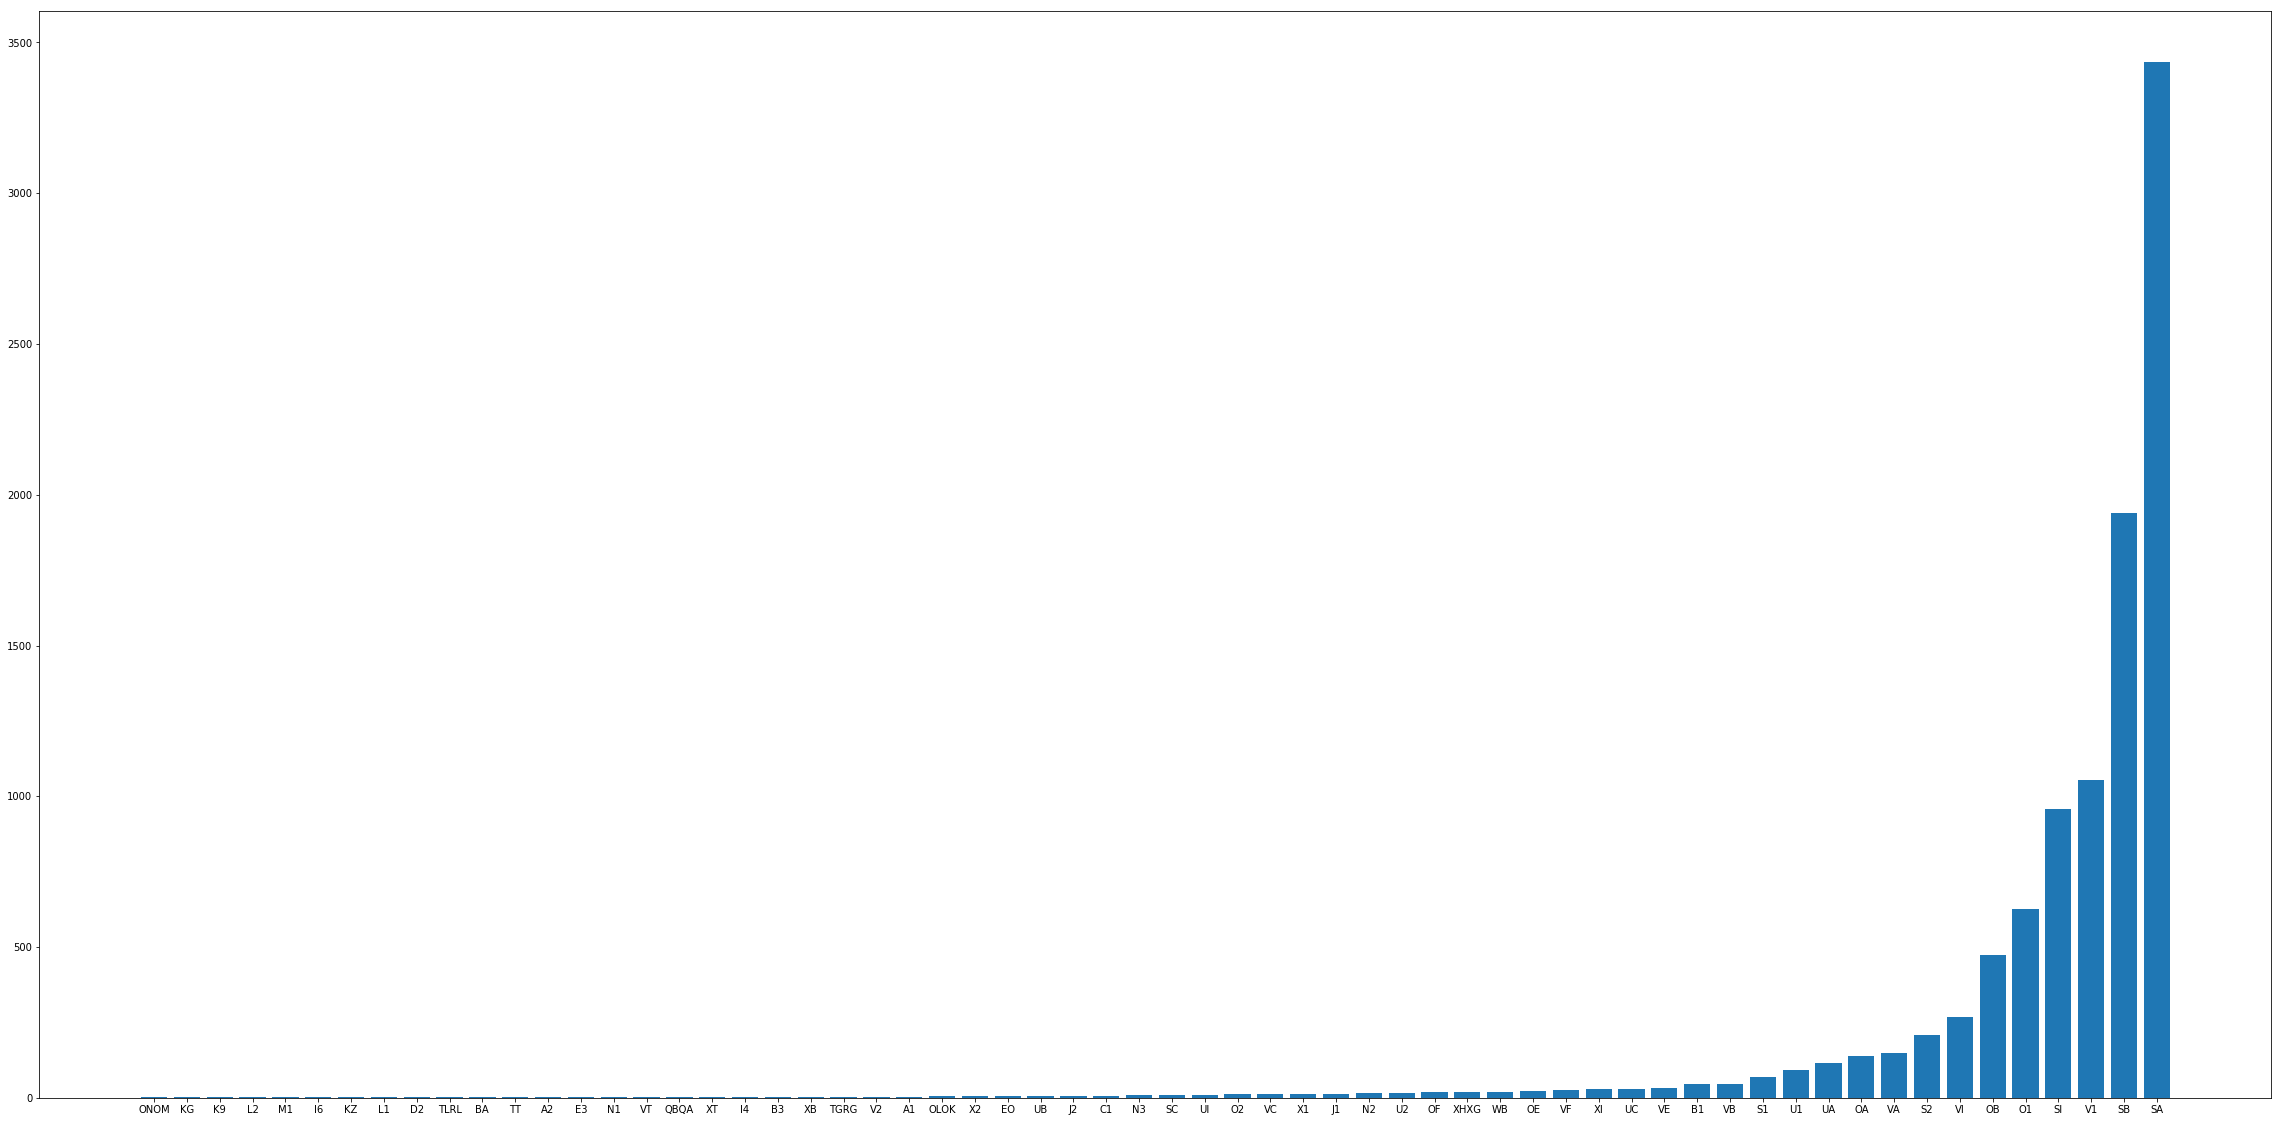

In [1187]:
plt.figure(figsize=(40,20))
plt.bar(pna_data_groupAgg.ORDR_TYPE_ID, pna_data_groupAgg.cnt)

In [1188]:
# Fucntion based

In [1189]:
# pna_data_enrich = pna_data_enrich.loc[(pna_data['ORRE'] == 'ORRE_2_OKEY')  & (pna_data['PRDI'] == 'PRDI_0_OKEY') & (pna_data['LORD'] == 'NONE_NONE_NONE')  & (pna_data['REAC'] == 'NONE_NONE_NONE')
#                 & (pna_data['PHRD'] == 'NONE_NONE_NONE')  & (pna_data['WODI'] == 'NONE_NONE_NONE') & (pna_data['RECO'] == 'NONE_NONE_NONE')  
#                  & (pna_data['FUCO'] == 'NONE_NONE_NONE') & (pna_data['MAUP'] == 'NONE_NONE_NONE')]

# 4. 데이터 그룹핑
- 4.2.1 주요 데이터 : LOB 및 WorkOdrTypeCode 등의 Key로 그룹핑
- 4.2.2 공정 기반 : 공정 기반으로 그룹핑

## 4.1 주요 데이터


In [1190]:
# 주요 데이터 - LOB
pna_group_lob = pna_data_enrich.groupby(['LOB'])['CUST_ORDR_NO']
pna_group_lob_agg = pna_group_lob.agg(['count','max','min']).reset_index().sort_values('count')
pna_group_lob_agg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_group_lob_agg

,LOB,cnt,max,min
5,WIBRO,20,20268M13245619N,20249M13511609N
3,PSTN,130,R02471TT279,14120A001721891
1,IOT,269,20270K14884469N,190819V1281949N
0,INTERNET,1368,R02471TG874,14142A107439590
2,IPTV,1589,TESTSLCLI603052,18085FJ0677209N
4,SOIP,6617,20272B86481089N,11231G318317191


In [1191]:
# 주요 데이터 - 오더타입
pna_group_type = pna_data_enrich.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO']
pna_group_type_agg = pna_group_type.agg(['count','max','min']).reset_index().sort_values('count')
pna_group_type_agg.rename(columns = {'count': 'cnt'}, inplace = True)
pna_group_type_agg

,ORDR_TYPE_ID,cnt,max,min
29,ONOM,1,202479R6201869N,202479R6201869N
14,KG,1,15086B417732891,15086B417732891
13,K9,1,20245GN26261591,20245GN26261591
17,L2,1,20259EP53500691,20259EP53500691
18,M1,1,20259ET53501191,20259ET53501191
10,I6,1,20259GD53502091,20259GD53502091
15,KZ,1,20259GC53501991,20259GC53501991
16,L1,1,20259EP53500691,20259EP53500691
6,D2,1,20259GP53502291,20259GP53502291
38,TLRL,1,R02471TL132,R02471TL132


## 4.2 공정

In [1213]:
pna_group_func = pna_data_enrich.copy()
pna_group_func = pna_group_func.groupby(['LOB', 'ORDR_TYPE_ID', 'ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO','FUCO', 'MAUP', 'ORCN', 'SA_FINAL'])['CUST_ORDR_NO','ORDR_TYPE_ID','WAITING_NUM']
pna_group_func_agg = pna_group_func.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO', 'count')])
pna_group_func_agg.rename(columns = {'count': 'cnt'}, inplace = True)

pna_group_func_agg

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


LOB ORDR_TYPE_ID         ORRE            PRDI            LORD  \
                                                                          
0    INTERNET           O1  ORRE_2_OKEY  NONE_NONE_NONE  NONE_NONE_NONE   
170      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
171      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
173      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
174      IPTV           VE  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
..        ...          ...          ...             ...             ...   
1    INTERNET           O1  ORRE_2_OKEY     PRDI_0_OKEY  NONE_NONE_NONE   
285      SOIP           SA  ORRE_2_OKEY     PRDI_0_OKEY  NONE_NONE_NONE   
125      IPTV           V1  ORRE_2_OKEY     PRDI_0_OKEY  NONE_NONE_NONE   
327      SOIP           SB  ORRE_2_OKEY     PRDI_2_OKEY  LORD_3_LORD700   
294      SOIP           SA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   

               PHRD            RECO            WODI            REAC  \
                                                                      
0    NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
170  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
171  NONE_NONE_NONE  NONE_NONE_NONE     WODI_2_OKEY  NONE_NONE_NONE   
173  NONE_NONE_NONE  NONE_NONE_NONE     WODI_2_OKEY     REAC_2_OKEY   
174  NONE_NONE_NONE  NONE_NONE_NONE     WODI_2_OKEY     REAC_2_OKEY   
..              ...             ...             ...             ...   
1    NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
285  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
125  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
327  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
294  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE     REAC_2_OKEY   

               JUJO            SWBO            FUCO            MAUP  \
                                                                      
0    NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
170  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  MAUP_3_MAUP534   
171  NONE_NONE_NONE  NONE_NONE_NONE     FUCO_2_OKEY  MAUP_3_MAUP534   
173  NONE_NONE_NONE  NONE_NONE_NONE     FUCO_2_OKEY  MAUP_3_MAUP534   
174  NONE_NONE_NONE  NONE_NONE_NONE     FUCO_2_OKEY  MAUP_3_MAUP534   
..              ...             ...             ...             ...   
1    NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
285  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
125  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
327  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
294  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

               ORCN               SA_FINAL CUST_ORDR_NO                   \
                                                    cnt              max   
0    NONE_NONE_NONE                   NONE            1  20260HB3405119N   
170  NONE_NONE_NONE        LIDA_ST-LMEN_ST            1  20262FU350764AN   
171  NONE_NONE_NONE                LIDA_ST            1  20260EM274497AN   
173  NONE_NONE_NONE  LIDA_ST-LMEN_MENE0005            1  20232GY459633AN   
174  NONE_NONE_NONE        LIDA_ST-LMEN_ST            1  20147FS536625AN   
..              ...                    ...          ...              ...   
1    NONE_NONE_NONE                LIDA_ST          507  20267ED2314819N   
285  NONE_NONE_NONE        LBCS_ST-LNOD_ST          784  20272AD6481019N   
125  NONE_NONE_NONE                LIDA_ST          896  20262G13507909N   
327  NONE_NONE_NONE        LBCS_ST-LNOD_ST         1161  20268G85970699N   
294  NONE_NONE_NONE        LBCS_ST-LNOD_ST         1911  20268GH5972379N   

                     ORDR_TYPE_ID         WAITING_NUM          
                 min          cnt max min         cnt max min  
0    20260HB3405119N            1  O1  O1           1   0   0  
170  

In [1227]:
pna_group_func_agg['Label'] = ''
pna_group_func_agg['Label'] = pna_group_func_agg['Label'].apply(list)

# 5. 오더분석
- 오더 분석은 정상, 에러(PNA), 오류(Defect)오더로 분류 한다.
- 기본적인 분석은 공정간 Grouping을 통한 유형 분류를 통해 수행한다.
- 다양한 오더 유형이 있는 공정 유형이 General하지 않은 경우에는 Detail한 분석을 수행한다.
 (공정 상태 조건을 통한 오더 정보 수집)


## 5.1 정상 오더 분류
### 5.1.1 공통
### 5.1.2 LOB

## 5.2 비정상 오더 분류
### 5.2.1 공통
### 5.2.2 LOB

### 5.1.1 정상 오더 분류
- 오더 완료

In [1228]:
# ORCN
func_groupAgg_normal_N0001 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('ORCN','')] == 'ORCN_2_OKEY-ORCN_2_OKEY') | ((pna_group_func_agg[('ORCN','')] == 'ORCN_2_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_7_OKEY']))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0001.index)].Label.apply(lambda x: x.append('N001') or x) 


# SWBO
func_groupAgg_normal_N0002 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('SWBO','')] == 'SWBO_0_OKEY-SWBO_0_OKEY') |  ((pna_group_func_agg[('SWBO','')] == 'SWBO_0_OKEY') & (pna_group_func_agg[('ORCN','')] == 'ORCN_2_OKEY'))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('SWBO','')] == 'SWBO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0002.index)].Label.apply(lambda x: x.append('N002') or x) 

# FUCO
func_groupAgg_normal_N0003 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (  
                                                      (pna_group_func_agg[('FUCO','')] == 'FUCO_0_OKEY-FUCO_0_OKEY') |  ((pna_group_func_agg[('FUCO','')] == 'FUCO_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('FUCO','')] == 'FUCO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0003.index)].Label.apply(lambda x: x.append('N003') or x) 

# JUJO
func_groupAgg_normal_N0004 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('JUJO','')] == 'JUJO_0_OKEY-JUJO_0_OKEY') |  ((pna_group_func_agg[('JUJO','')] == 'JUJO_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('JUJO','')] == 'JUJO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0004.index)].Label.apply(lambda x: x.append('N004') or x) 

# REAC
func_groupAgg_normal_N0005 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('REAC','')].isin(['REAC_6_OKEY-REAC_6_OKEY', 'REAC_0_OKEY-REAC_0_OKEY', 'REAC_0_OKEY-REAC_6_OKEY', 'REAC_6_OKEY-REAC_0_OKEY'])) |  ((pna_group_func_agg[('REAC','')].isin(['REAC_0_OKEY', 'REAC_6_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('REAC','')].isin(['REAC_0_OKEY','REAC_6_OKEY']))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0005.index)].Label.apply(lambda x: x.append('N005') or x) 

# RECO
func_groupAgg_normal_N0006 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('RECO','')] == 'RECO_0_OKEY-RECO_0_OKEY') |  ((pna_group_func_agg[('RECO','')] == 'RECO_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('RECO','')] == 'RECO_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0006.index)].Label.apply(lambda x: x.append('N006') or x) 

# WODI
func_groupAgg_normal_N0007 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY-WODI_0_OKEY') |  ((pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY')))]

# WODI additional
func_groupAgg_normal_N0007 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('WODI','')] == 'WODI_0_OKEY-WODI_0_OKEY') |  ((pna_group_func_agg[('WODI','')] == 'WODI_6_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('WODI','')] == 'WODI_6_OKEY')))]


pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0007.index)].Label.apply(lambda x: x.append('N007') or x) 

# PHRD
func_groupAgg_normal_N0008 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('PHRD','')] == 'PHRD_0_OKEY-PHRD_0_OKEY') |  ((pna_group_func_agg[('PHRD','')] == 'PHRD_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PHRD','')] == 'PHRD_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0008.index)].Label.apply(lambda x: x.append('N008') or x) 

# LORD
func_groupAgg_normal_N0009 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('LORD','')] == 'LORD_0_OKEY-LORD_0_OKEY') |  ((pna_group_func_agg[('LORD','')] == 'LORD_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('LORD','')] == 'LORD_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0009.index)].Label.apply(lambda x: x.append('N009') or x) 

# PRDI
func_groupAgg_normal_N0010 = pna_group_func_agg.loc[((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) & 
                                                     (
                                                      (pna_group_func_agg[('PRDI','')] == 'PRDI_0_OKEY-PRDI_0_OKEY') |  ((pna_group_func_agg[('PRDI','')] == 'PRDI_0_OKEY') & (pna_group_func_agg[('WAITING_NUM','min')] > 0))
                                                     )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PRDI','')] == 'PRDI_0_OKEY')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_N0010.index)].Label.apply(lambda x: x.append('N010') or x) 




333                [N010]
195                [N010]
126                [N010]
138    [N003, N007, N010]
266                [N010]
283                [N010]
226                [N010]
243                [N010]
332                [N010]
314                [N010]
58                 [N010]
68                 [N010]
59                 [N010]
14     [N006, N007, N010]
98     [N003, N007, N010]
44                 [N010]
345                [N010]
119                [N010]
110                [N010]
71                 [N010]
135                [N010]
286                [N010]
179          [N001, N010]
165                [N010]
8                  [N010]
343                [N010]
315                [N010]
169                [N010]
66                 [N010]
73                 [N010]
93                 [N010]
54                 [N010]
80                 [N010]
180                [N010]
265                [N010]
15                 [N010]
115                [N010]
256                [N010]
344         

In [1229]:
# Special condition for normal order
# Pair Order
func_groupAgg_normal_P0001 = pna_group_func_agg.loc[(pna_group_func_agg[('JUJO','')].isin(['JUJO_0_OKEY-JUJO_2_OKEY', 'JUJO_2_OKEY-JUJO_0_OKEY'])) & (pna_group_func_agg[('FUCO', '')] == 'FUCO_2_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0001.index)].Label.apply(lambda x: x.append('P0001') or x) 

func_groupAgg_normal_P0002 = pna_group_func_agg.loc[(pna_group_func_agg[('PRDI','')].isin(['PRDI_0_OKEY-PRDI_2_OKEY', 'PRDI_2_OKEY-PRDI_0_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0002.index)].Label.apply(lambda x: x.append('P0002') or x) 


func_groupAgg_normal_P0003 = pna_group_func_agg.loc[(pna_group_func_agg[('PRDI','')].isin(['PRDI_0_OKEY-PRDI_2_OKEY', 'PRDI_2_OKEY-PRDI_0_OKEY'])) & (pna_group_func_agg[('WODI', '')] == 'WODI_6_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0002.index)].Label.apply(lambda x: x.append('P0003') or x) 

func_groupAgg_normal_P0004 = pna_group_func_agg.loc[(pna_group_func_agg[('JUJO','')] == 'JUJO_2_OKEY-JUJO_0_OKEY') & (pna_group_func_agg[('REAC', '')] == 'REAC_2_OKEY-REAC_2_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_P0004.index)].Label.apply(lambda x: x.append('P0004') or x) 


Series([], Name: Label, dtype: object)

In [1230]:
# Special condition for normal order
# Service activation waiting Order

# DEL Waiting
func_groupAgg_normal_S0001 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY') & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('SA_FINAL','')].str.contains('LNOD_ST'))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0001.index)].Label.apply(lambda x: x.append('S0001') or x) 

# IDMS Waiting
func_groupAgg_normal_S0003 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY')  & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('SA_FINAL','')] == 'LIDA_ST') & (pna_group_func_agg[('ORDR_TYPE_ID','')].isin(['UA','UB','U1','U2','UC','UI','SC', 'SI', 'SB']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0003.index)].Label.apply(lambda x: x.append('S0003') or x) 

# NO WODI and waiting for BSCMS
func_groupAgg_normal_S0004 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY') & (pna_group_func_agg[('PRDI', '')] == 'PRDI_2_OKEY') & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('WODI', '')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('SA_FINAL','')] == 'LBCS_ST')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0004.index)].Label.apply(lambda x: x.append('S0004') or x) 

# IPTV Timer
func_groupAgg_normal_S0005 = pna_group_func_agg.loc[(pna_group_func_agg[('LOB','')] == 'IPTV')  & (pna_group_func_agg[('ORRE','')] == 'ORRE_2_OKEY') & (pna_group_func_agg[('PRDI', '')] == 'PRDI_2_OKEY') & (pna_group_func_agg[('LORD', '')] == 'LORD_2_OKEY')
                                                   & (pna_group_func_agg[('WODI', '')].isin(['WODI_2_OKEY','NONE_NONE_NONE'])) & ~(pna_group_func_agg[('SA_FINAL','')].str.contains('LMEN_ST'))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_normal_S0005.index)].Label.apply(lambda x: x.append('S0005') or x) 


171          [S0005]
173          [S0005]
175          [S0005]
181    [N001, S0005]
130          [S0005]
141          [S0005]
142    [N001, S0005]
146          [S0005]
148          [S0005]
186          [S0005]
188          [S0005]
162          [S0005]
187          [S0005]
131          [S0005]
Name: Label, dtype: object

In [1231]:
# PNA Error 오더
# MAUP
func_groupAgg_error_E0001 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('MAUP','')].str.contains('MAUP_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('MAUP','')].str.contains('MAUP_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0001.index)].Label.apply(lambda x: x.append('E0001') or x) 

# FUCO
func_groupAgg_error_E0002 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('FUCO','')].str.contains('FUCO_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('FUCO','')].str.contains('FUCO_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0002.index)].Label.apply(lambda x: x.append('E0002') or x) 

# REAC
func_groupAgg_error_E0003 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('REAC','')].str.contains('REAC_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('REAC','')].str.contains('REAC_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0003.index)].Label.apply(lambda x: x.append('E0003') or x) 

# RECO
func_groupAgg_error_E0004 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('RECO','')].str.contains('RECO_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('RECO','')].str.contains('RECO_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0004.index)].Label.apply(lambda x: x.append('E0004') or x) 

# PHRD
func_groupAgg_error_E0005 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('PHRD','')].str.contains('PHRD_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PHRD','')].str.contains('PHRD_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0005.index)].Label.apply(lambda x: x.append('E0005') or x) 

# LORD
func_groupAgg_error_E0006 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('LORD','')].str.contains('LORD_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('LORD','')].str.contains('LORD_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0006.index)].Label.apply(lambda x: x.append('E0006') or x) 

# PRDI
func_groupAgg_error_E0007 = pna_group_func_agg.loc[(((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() > 3) &
                                                    (
                                                        (pna_group_func_agg[('PRDI','')].str.contains('PRDI_3')) & (pna_group_func_agg[('WAITING_NUM','min')] > 0)
                                                    )
                                                   | ((pna_group_func_agg[('ORDR_TYPE_ID','max')].str.len() < 3) & (pna_group_func_agg[('PRDI','')].str.contains('PRDI_3')))))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_E0007.index)].Label.apply(lambda x: x.append('E0007') or x) 

# 미처리
func_groupAgg_error_EP001 = pna_group_func_agg.loc[(pna_group_func_agg[('WODI','')].str.contains('WODI_5'))]
                                                   
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_EP001.index)].Label.apply(lambda x: x.append('EP001') or x) 


149          [E0001, EP001]
150          [E0003, EP001]
301           [N001, EP001]
331    [N001, S0003, EP001]
341           [N003, EP001]
105    [N003, S0003, EP001]
20            [N006, EP001]
Name: Label, dtype: object

In [1232]:
# Service activation error
func_groupAgg_error_ES001 = pna_group_func_agg.loc[((pna_group_func_agg[('LOB','')] == 'SOIP') & (pna_group_func_agg[('SA_FINAL','')].str.contains('LIDA_0')))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_error_ES001.index)].Label.apply(lambda x: x.append('ES001') or x) 


Series([], Name: Label, dtype: object)

## 5.2 Defect
### 5.2.1 공통

In [1233]:
# Amending 강제 준공
func_groupAgg_defect_D0001 = pna_group_func_agg.loc[(pna_group_func_agg[('PRDI','')].isin(['PRDI_7_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] == 0) 
                                                    & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0001.index)].Label.apply(lambda x: x.append('D0001') or x) 

func_groupAgg_defect_D0001 = pna_group_func_agg.loc[(pna_group_func_agg[('LORD','')].isin(['LORD_7_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] == 0) 
                                                   & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0001.index)].Label.apply(lambda x: x.append('D0001') or x) 

# ORRE Only
func_groupAgg_defect_D0002 = pna_group_func_agg.loc[(pna_group_func_agg[('ORRE','')].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY']))  & (pna_group_func_agg[('PRDI','')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('LORD','')] == 'NONE_NONE_NONE')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_group_func_agg[('PHRD','')] == 'NONE_NONE_NONE')  & (pna_group_func_agg[('WODI','')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('RECO','')] == 'NONE_NONE_NONE')  
                 & (pna_group_func_agg[('FUCO','')] == 'NONE_NONE_NONE') & (pna_group_func_agg[('MAUP','')] == 'NONE_NONE_NONE')]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0002.index)].Label.apply(lambda x: x.append('D0002') or x) 

# No inprogress 
func_groupAgg_defect_D0003 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('SA_FINAL','')] == 'NONE')
                                                   & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0003.index)].Label.apply(lambda x: x.append('D0003') or x) 


# No inprogress 
func_groupAgg_defect_D0003 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('SA_FINAL','')] == 'NONE')
                                                   & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0003.index)].Label.apply(lambda x: x.append('D0003') or x) 


# LORD 001 status 
func_groupAgg_defect_DS001 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('LORD','')].str.contains('LORD_1_OKEY')) 
                                                     &  ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DS001.index)].Label.apply(lambda x: x.append('DS001') or x) 


316    [DS001]
Name: Label, dtype: object

In [1234]:
### 5.2.2 LOB WIse

In [1235]:
# IPTV
func_groupAgg_defect_DV001 = pna_group_func_agg.loc[(pna_group_func_agg[('LORD','')].isin(['LORD_2_OKEY'])) & (pna_group_func_agg[('WAITING_NUM','min')] == 0) 
                                                    & (pna_group_func_agg[('SA_FINAL','')].str.contains('LMEN_ST')) & (pna_group_func_agg[('ORCN','')] != 'ORCN_2_OKEY')]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DV001.index)].Label.apply(lambda x: x.append('DV001') or x) 
func_groupAgg_defect_DI001

LOB ORDR_TYPE_ID         ORRE            PRDI            LORD  \
                                                                         
0   INTERNET           O1  ORRE_2_OKEY  NONE_NONE_NONE  NONE_NONE_NONE   
42  INTERNET           OB  ORRE_2_OKEY     PRDI_2_OKEY     LORD_7_OKEY   
16  INTERNET           OA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
33  INTERNET           OA  ORRE_2_OKEY     PRDI_2_OKEY  NONE_NONE_NONE   

              PHRD            RECO            WODI            REAC  \
                                                                     
0   NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
42  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
16  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
33  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

              JUJO            SWBO            FUCO            MAUP  \
                                                                     
0   NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
42  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
16  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
33  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

              ORCN SA_FINAL CUST_ORDR_NO                                    \
                                     cnt              max              min   
0   NONE_NONE_NONE     NONE            1  20260HB3405119N  20260HB3405119N   
42  NONE_NONE_NONE  LIDA_ST            1  17341H41156339N  17341H41156339N   
16  NONE_NONE_NONE  LIDA_ST            1  170489A76979190  170489A76979190   
33  NONE_NONE_NONE  LIDA_ST            3  20247AJ6202509N  202479T6201909N   

   ORDR_TYPE_ID         WAITING_NUM                                 Label  
            cnt max min         cnt max min                                
0             1  O1  O1           1   0   0  [D0002, D0003, D0003, DI001]  
42            1  OB  OB           1   0   0                [D0001, DI001]  
16            1  OA  OA           1   0   0                       [DI001]  
33            3  OA  OA           3   0   0                       [DI001]

In [1236]:
# Internet

# No inprogress 
func_groupAgg_defect_DI001 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('LOB','')] == 'INTERNET') 
                                                     & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DI001.index)].Label.apply(lambda x: x.append('DI001') or x) 

func_groupAgg_defect_DI001

LOB ORDR_TYPE_ID         ORRE            PRDI            LORD  \
                                                                         
0   INTERNET           O1  ORRE_2_OKEY  NONE_NONE_NONE  NONE_NONE_NONE   
42  INTERNET           OB  ORRE_2_OKEY     PRDI_2_OKEY     LORD_7_OKEY   
16  INTERNET           OA  ORRE_2_OKEY     PRDI_2_OKEY     LORD_2_OKEY   
33  INTERNET           OA  ORRE_2_OKEY     PRDI_2_OKEY  NONE_NONE_NONE   

              PHRD            RECO            WODI            REAC  \
                                                                     
0   NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
42  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
16  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
33  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

              JUJO            SWBO            FUCO            MAUP  \
                                                                     
0   NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
42  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
16  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
33  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

              ORCN SA_FINAL CUST_ORDR_NO                                    \
                                     cnt              max              min   
0   NONE_NONE_NONE     NONE            1  20260HB3405119N  20260HB3405119N   
42  NONE_NONE_NONE  LIDA_ST            1  17341H41156339N  17341H41156339N   
16  NONE_NONE_NONE  LIDA_ST            1  170489A76979190  170489A76979190   
33  NONE_NONE_NONE  LIDA_ST            3  20247AJ6202509N  202479T6201909N   

   ORDR_TYPE_ID         WAITING_NUM                                 Label  
            cnt max min         cnt max min                                
0             1  O1  O1           1   0   0  [D0002, D0003, D0003, DI001]  
42            1  OB  OB           1   0   0                [D0001, DI001]  
16            1  OA  OA           1   0   0                       [DI001]  
33            3  OA  OA           3   0   0                       [DI001]

In [1237]:
# SOIP & IOT

# No inprogress 
func_groupAgg_defect_DS001 = pna_group_func_agg.loc[(pna_group_func_agg[('WAITING_NUM','min')] == 0) & (pna_group_func_agg[('LOB','')].isin(['IOT', 'SOIP']))
                                                    & (pna_group_func_agg[('PRDI','')] == 'PRDI_2_OKEY') 
                                                     & (pna_group_func_agg[('LORD','')] == 'NONE_NONE_NONE')  & ~(pna_group_func_agg[('ORCN','')].isin(['ORCN_2_OKEY', 'ORCN_2_OKEY-ORCN_2_OKEY']))]
pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_DS001.index)].Label.apply(lambda x: x.append('DS001') or x) 

func_groupAgg_defect_DS001

LOB ORDR_TYPE_ID         ORRE         PRDI            LORD  \
                                                                   
124   IOT           UI  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
277  SOIP           S2  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
310  SOIP           SA  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
109   IOT           UA  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   
330  SOIP           SB  ORRE_2_OKEY  PRDI_2_OKEY  NONE_NONE_NONE   

               PHRD            RECO            WODI            REAC  \
                                                                      
124  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
277  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
310  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
109  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
330  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

               JUJO            SWBO            FUCO            MAUP  \
                                                                      
124  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
277  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
310  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
109  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   
330  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE  NONE_NONE_NONE   

               ORCN         SA_FINAL CUST_ORDR_NO                   \
                                              cnt              max   
124  NONE_NONE_NONE          LIDA_ST            1  20247BJ6202889N   
277  NONE_NONE_NONE          LIDA_ST            1  202479L6199989N   
310  NONE_NONE_NONE  LBCS_ST-LNOD_ST            2  202540S5900589N   
109  NONE_NONE_NONE          LIDA_ST            3  20247AK6202539N   
330  NONE_NONE_NONE  LBCS_ST-LNOD_ST            7  20267GT5959879N   

                     ORDR_TYPE_ID         WAITING_NUM            Label  
                 min          cnt max min         cnt max min           
124  20247BJ6202889N            1  UI  UI           1   0   0  [DS001]  
277  202479L6199989N            1  S2  S2           1   0   0  [DS001]  
310  202540S5900439N            2  SA  SA           2   0   0  [DS001]  
109  202479U6201959N            3  UA  UA           3   0   0  [DS001]  
330  20267GT5959529N            7  SB  SB           7   0   0  [DS001]

In [1240]:
pna_group_func_agg['Label'] = pna_group_func_agg.apply(lambda row: calculateLabel(row), axis = 1)
pna_group_func_agg.sort_values(['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO', 'FUCO', 'MAUP', 'ORCN', 'SA_FINAL'])
saveDataToCSV("./anal/pna_group_func_agg_E007.csv",pna_group_func_agg)

AttributeError: 'str' object has no attribute 'contains'

In [1175]:

pna_group_func_agg[pna_group_func_agg.index.isin(func_groupAgg_defect_D0001.index)].Label.apply(lambda x: x.append('D0001') or x) 



# DC001-ORRE Only completed
target_dt_dc001 = pna_data_enrich.loc[(pna_data_enrich['ORRE'].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY']))  & (pna_data_enrich['PRDI'] == 'NONE_NONE_NONE') & (pna_data_enrich['LORD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_data_enrich['PHRD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['WODI'] == 'NONE_NONE_NONE') & (pna_data_enrich['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data_enrich['FUCO'] == 'NONE_NONE_NONE') & (pna_data_enrich['MAUP'] == 'NONE_NONE_NONE')]

# DC002-No in-progress component
target_dt_dc002 = pna_data_enrich.loc[(pna_data_enrich['sysDtLastExecDtDelta'] > 10) & (pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['SA'] == 'NONE') & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE')
                                     & ~(pna_data_enrich['ORDR_TYPE_ID'].isin(['AW', 'BA','BQ','KF', 'QA']))
                                     ]

AttributeError: 'set' object has no attribute 'append'

### Anaysis target orders

### 미완료 오더 중 진행 중 공정 Zero

In [ ]:
target_df = pna_data_enrich.loc[(pna_data_enrich['ORCN'] == 'NONE_NONE_NONE') & (pna_data_enrich['WAITING_NUM'] == 0)]

In [ ]:
pna_data_group = target_dt_dc002.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO', 'PROD_ID']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO','count')])
#.sort_values(pna_data_group.get_level_values(1) == 'count')
#column name change
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)

In [ ]:
pna_data_groupAgg.head()
# pna_data_groupAgg.columns = pna_data_groupAgg.columns.to_flat_index()

In [ ]:
pna_data_enrich.loc[(pna_data_enrich['ORCN'] == 'NONE_NONE_NONE') & (pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['ORDR_TYPE_ID'] == 'SA')]

In [ ]:
### 희망일 초과 오더

In [ ]:
target_dt = pna_data_enrich.loc[(pna_data_enrich['hopeDtSysDtDelta'] < 0) & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE')]
target_dt = pna_data_enrich.loc[(pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE') & (pna_data_enrich['sysDtLastExecDtDelta'] > 10 )]

In [ ]:
target_dt = target_dt.sort_values(by = ['LOB', 'ORDR_TYPE_ID', 'sysDtLastExecDtDelta','CUST_ORDR_NO'])
target_dt.head()

## Common defect

In [ ]:
# DC001-ORRE Only completed
target_dt_dc001 = pna_data_enrich.loc[(pna_data_enrich['ORRE'].isin(['ORRE_2_OKEY', 'ORRE_2_OKEY-ORRE_2_OKEY']))  & (pna_data_enrich['PRDI'] == 'NONE_NONE_NONE') & (pna_data_enrich['LORD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_data_enrich['PHRD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['WODI'] == 'NONE_NONE_NONE') & (pna_data_enrich['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data_enrich['FUCO'] == 'NONE_NONE_NONE') & (pna_data_enrich['MAUP'] == 'NONE_NONE_NONE')]

# DC002-No in-progress component
target_dt_dc002 = pna_data_enrich.loc[(pna_data_enrich['sysDtLastExecDtDelta'] > 10) & (pna_data_enrich['WAITING_NUM'] == 0) & (pna_data_enrich['SA'] == 'NONE') & (pna_data_enrich['ORCN'] == 'NONE_NONE_NONE')
                                     & ~(pna_data_enrich['ORDR_TYPE_ID'].isin(['AW', 'BA','BQ','KF', 'QA']))
                                     ]
target_dt_dc002[target_dt_dc002['LOB']=='PSTN']

## LOB

## 1.1 Internet

In [ ]:
pna_data_enrich_int = pna_data_enrich.loc[(pna_data_enrich['LOB'] == 'INTERNET') & (~pna_data_enrich['ORDR_TYPE_ID'].isin(['XV', 'XQ', 'ON', 'XP']))]
pna_data_group = pna_data_enrich_int.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO', 'PROD_ID']
pna_data_groupAgg = pna_data_group.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO','count')])
pna_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)

### SOIP for labeling

In [ ]:
# defect list
# 1 ORRE Only
target_dt_d1 = target_dt.loc[(pna_data['ORRE'] == 'ORRE_2_OKEY')  & (pna_data['PRDI'] == 'NONE_NONE_NONE') & (pna_data['LORD'] == 'NONE_NONE_NONE')  & (pna_data['REAC'] == 'NONE_NONE_NONE')
                & (pna_data['PHRD'] == 'NONE_NONE_NONE')  & (pna_data['WODI'] == 'NONE_NONE_NONE') & (pna_data['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data['FUCO'] == 'NONE_NONE_NONE') & (pna_data['MAUP'] == 'NONE_NONE_NONE')]

target_dt_d1

In [ ]:
target_dt_sa = target_dt.loc[(pna_data_enrich['ORDR_TYPE_ID'] == 'SA')]

In [ ]:
target_dt_sa.group = target_dt_sa.groupby(['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO','FUCO', 'MAUP', 'ORCN'])

In [ ]:
target_data_group = target_dt_sa.groupby(['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO','FUCO', 'MAUP', 'ORCN', 'SA'])['CUST_ORDR_NO','ORDR_TYPE_ID','PROD_ID']
target_data_groupAgg = target_data_group.agg(['count','max','min']).reset_index().sort_values([('CUST_ORDR_NO', 'count')])
#column name change
target_data_groupAgg.rename(columns = {'count': 'cnt'}, inplace = True)

target_data_groupAgg

# Common analysis tools

In [652]:
pna_data_enrich

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta
2,2020-09-24 11:22:50,13102D408414791,3,13102D408414791,SOIP,SC,0V02,20-10893664731,R00640,2020-09-23 16:59:24,2020-09-24 09:04:04,2013-04-23 11:00:00,2013-04-23 11:00:00,2099-12-31 23:59:59,2020-09-24 09:04:04,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_2_OKEY,MAUP_3_MAUP608,NONE_NONE_NONE,LIDA_CP-LIDA_ST-,1,LIDA_ST,138.0,138.0,-3903863.0
6,2020-09-24 11:22:50,15153F408606691,1,15153F408606691,SOIP,SC,0V02,20-11158084471,R02414,2015-06-02 15:48:50,2020-09-24 10:19:06,2015-06-02 15:00:00,2015-06-02 15:00:00,2020-09-24 10:19:06,2020-09-24 10:18:58,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_2_OKEY,MAUP_2_OKEY,ORCN_2_OKEY,LIDA_ST-LIDA_CP-LIDA_CP-,0,LIDA_CP,63.0,63.0,-2794823.0
16,2020-09-24 11:22:50,17086AI075648A0,32,17086AI075648-14332162380-57,IPTV,VE,0701,20-14332162380,R00708,2017-03-27 10:28:07,2020-09-23 15:31:38,2020-09-28 14:00:00,2020-09-28 14:00:00,2099-12-31 23:59:59,2020-09-23 15:31:38,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,2,LIDA_CP,1191.0,1191.0,5917.0
19,2020-09-24 11:22:50,17165BI695479AN,10,17165BI695479-19254211760-57,IPTV,VE,0701,20-19254211760,R03957,2017-06-14 11:27:21,2020-09-23 14:35:03,2020-09-24 13:00:00,2020-09-24 13:00:00,2099-12-31 23:59:59,2020-09-23 14:35:03,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,2,LIDA_CP,1247.0,1247.0,97.0
20,2020-09-24 11:22:50,17173538963279N,4,1717353896327-21715876720,INTERNET,OF,088M,10-21715876720,R00459,2020-09-24 09:45:23,2020-09-24 09:45:23,2020-10-05 16:00:00,2020-10-05 16:00:00,2099-12-31 23:59:59,2020-09-24 09:45:24,ORRE_2_OKEY,PRDI_0_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-,1,LIDA_ST,97.0,97.0,16117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113710,2020-09-24 11:22:50,R08495TG1131,1,R08495TG1131,INTERNET,TGRG,099S,20-62052396184,R08495,2020-09-24 09:56:31,2020-09-24 09:58:14,2020-09-24 09:56:30,2020-09-24 09:56:30,2020-09-24 09:58:14,2020-09-24 09:58:11,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,REAC_2_OKEY-REAC_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_2_OKEY,MAUP_2_OKEY,ORCN_2_OKEY-ORCN_2_OKEY,NONE,0,,84.0,84.0,-87.0
113711,2020-09-24 11:22:50,R08495TG1132,1,R08495TG1132,INTERNET,TGRG,099S,20-68103712839,R08495,2020-09-24 09:56:57,2020-09-24 10:09:17,2020-09-24 09:56:57,2020-09-24 09:56:57,2020-09-24 10:09:17,2020-09-24 10:09:14,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,REAC_2_OKEY-REAC_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_2_OKEY,MAUP_2_OKEY,ORCN_2_OKEY-ORCN_2_OKEY,NONE,0,,73.0,73.0,-86.0
113712,2020-09-24 11:22:50,R08495TG1133,1,R08495TG1133,INTERNET,TGRG,099P,20-23013576200,R08495,2020-09-24 09:57:55,2020-09-24 10:00:17,2020-09-24 09:57:55,2020-09-24 09:57:55,2020-09-24 10:00:17,2020-09-24 10:00:14,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,REAC_2_OKEY-REAC_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,FUCO_2_OKEY,MAUP_2_OKEY,ORCN_2_OKEY-ORCN_2_OKEY,NONE,0,,82.0,82.0,-85.0
113713,2020-09-24 11:22:50,R08495TG1134,1,R08495TG1134,INTERNET,

In [667]:
# grouping
check_data = pna_data_enrich.loc[(pna_data_enrich['ORRE'] == 'ORRE_2_OKEY')  & (pna_data_enrich['PRDI'] == 'PRDI_2_OKEY') & (pna_data_enrich['LORD'] == 'LORD_2_OKEY')  & (pna_data_enrich['REAC'] == 'NONE_NONE_NONE')
                & (pna_data_enrich['PHRD'] == 'NONE_NONE_NONE')  & (pna_data_enrich['WODI'] == 'WODI_6_OKEY') & (pna_data_enrich['RECO'] == 'NONE_NONE_NONE')  
                 & (pna_data_enrich['FUCO'] == 'NONE_NONE_NONE') & (pna_data_enrich['MAUP'] == 'NONE_NONE_NONE') & (pna_data_enrich['SA_FINAL'] == 'LIDA_CP')].copy()

check_data.head()

,QUERY_DATE,CUST_ORDR_NO,CUST_ORDR_VER_NO,ORDR_COMPOSI_IDFY_ID,LOB,ORDR_TYPE_ID,PROD_ID,PROD_ORDR_SEQ,OBDNG_ID,FIRST_CRET_DT,LAST_CHG_DT,OPN_HOPE_DATE,RMVL_HOPE_DATE,ICIS_CMPLN_DATE,LAST_PRCS_EXEC,ORRE,PRDI,LORD,PHRD,RECO,WODI,REAC,JUJO,SWBO,FUCO,MAUP,ORCN,SA,WAITING_NUM,SA_FINAL,sysDtLastChgDtDelta,sysDtLastExecDtDelta,hopeDtSysDtDelta
56,2020-09-24 11:22:50,19070HF0164049N,26,19070HF016404-13788260970,INTERNET,XI,088M,10-13788260970,R00415,2019-03-11 17:21:48,2020-09-23 16:42:10,2020-10-06 16:00:00,2020-10-06 16:00:00,2099-12-31 23:59:59,2020-09-23 16:42:06,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,1120.0,1120.0,17557.0
428,2020-09-24 11:22:50,20120D65694829N,5,20120D6569482-69036785198,INTERNET,XI,088M,10-69036785198,R02217,2020-04-29 13:06:48,2020-09-23 17:06:16,2020-10-05 12:00:00,2020-10-05 12:00:00,2099-12-31 23:59:59,2020-09-23 17:06:16,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,1096.0,1096.0,15877.0
1315,2020-09-24 11:22:50,20220BM4463439N,7,20220BM446343-24516301710,INTERNET,XI,088M,10-24516301710,R02810,2020-08-07 11:35:51,2020-09-23 17:07:45,2020-09-24 14:00:00,2020-09-24 14:00:00,2099-12-31 23:59:59,2020-09-23 17:07:46,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,1095.0,1095.0,157.0
1576,2020-09-24 11:22:50,20231G96985899N,8,20231G9698589-61100991903,IPTV,VA,0701,10-61100991903,R02238,2020-08-18 16:11:58,2020-09-23 13:39:26,2020-09-24 15:00:00,2020-09-24 15:00:00,2099-12-31 23:59:59,2020-09-23 13:39:26,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,1303.0,1303.0,217.0
2159,2020-09-24 11:22:50,20239GU8755049N,19,20239GU875504-23014254770,INTERNET,XI,099S,10-23014254770,R01225,2020-08-26 16:50:56,2020-09-23 15:53:18,2020-10-05 16:00:00,2020-10-05 16:00:00,2099-12-31 23:59:59,2020-09-23 15:53:18,ORRE_2_OKEY,PRDI_2_OKEY,LORD_2_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,WODI_6_OKEY,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,NONE_NONE_NONE,LIDA_ST-LIDA_CP-,1,LIDA_CP,1169.0,1169.0,16117.0


In [668]:
# 주요 데이터 - 오더타입
chk_group_type = check_data.groupby(['ORDR_TYPE_ID'])['CUST_ORDR_NO']
chk_group_type_agg = chk_group_type.agg(['count','max','min']).reset_index().sort_values('count')
chk_group_type_agg.rename(columns = {'count': 'cnt'}, inplace = True)
chk_group_type_agg

,ORDR_TYPE_ID,cnt,max,min
0,VA,1,20231G96985899N,20231G96985899N
1,XI,447,20268AU7478199N,19070HF0164049N


In [669]:
check_data_keys = check_data.drop(columns=['ORRE', 'PRDI', 'LORD', 'PHRD', 'RECO', 'WODI', 'REAC', 'JUJO', 'SWBO', 'FUCO', 'MAUP', 'ORCN', 'SA'])

In [673]:
check_data_keys_group = check_data_keys.groupby(['ORDR_TYPE_ID', 'PROD_ID'])

In [675]:
check_data_keys_group.count()

QUERY_DATE  CUST_ORDR_NO  CUST_ORDR_VER_NO  \
ORDR_TYPE_ID PROD_ID                                               
VA           0701              1             1                 1   
XI           0784             10            10                10   
             0799              4             4                 4   
             0821             11            11                11   
             0822             98            98                98   
             0885              1             1                 1   
             0886              2             2                 2   
             088L             56            56                56   
             088M            202           202               202   
             088N              1             1                 1   
             099P             16            16                16   
             099S             45            45                45   
             099U              1             1                 1   

                      ORDR_COMPOSI_IDFY_ID  LOB  PROD_ORDR_SEQ  OBDNG_ID  \
ORDR_TYPE_ID PROD_ID                                                       
VA           0701                        1    1              1         1   
XI           0784                       10   10             10        10   
             0799                        4    4              4         4   
             0821                       11   11             11        11   
             0822                       98   98             98        98   
             0885                        1    1              1         1   
             0886                        2    2              2         2   
             088L                       56   56             56        56   
             088M                      202  202            202       202   
             088N                        1    1              1         1   
             099P                       16   16             16        16   
             099S                       45   45             45        45   
             099U                        1    1              1         1   

                      FIRST_CRET_DT  LAST_CHG_DT  OPN_HOPE_DATE  \
ORDR_TYPE_ID PROD_ID                                              
VA           0701                 1            1              1   
XI           0784                10           10             10   
             0799                 4            4              4   
             0821                11           11             11   
             0822                98           98             98   
             0885                 1            1              1   
             0886                 2            2              2   
             088L                56           56             56   
             088M               202          202            202   
             088N                 1            1              1   
             099P                16           16             16   
             099S                45           45             45   
             099U                 1            1              1   

                      RMVL_HOPE_DATE  ICIS_CMPLN_DATE  LAST_PRCS_EXEC  \
ORDR_TYPE_ID PROD_ID                                                    
VA           0701                  1                1               1   
XI           0784                 10               10              10   
             0799                  4                4               4   
             0821                 11               11              11   
             0822                 98               98              98   
             0885                  1                1               1   
             0886                  2                2               2   
             088L                 56               56              56   
             088M                202              202             202   
             088N                  1               